<a href="https://colab.research.google.com/github/Giffy/EMNIST-character-recognition/blob/master/EMNIST_byClass_GPU_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EMNIST character classification by class

This is the first approach to EMNIST character classification, based in reference code:

https://github.com/j05t/emnist 

https://nextjournal.com/gkoehler/digit-recognition-with-keras


#Download dataset and inflate

## Download and inflate dataset

In [1]:
# Check if already downloaded
check = !if [ -d 'dataset/' ]; then echo "1" ; else echo "0"; fi
if (check[0] is '0' ):
  !mkdir dataset
  !wget 'https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/matlab.zip'
  !unzip matlab.zip -d /content/dataset

--2018-11-29 20:20:18--  https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/matlab.zip
Resolving www.itl.nist.gov (www.itl.nist.gov)... 129.6.13.51, 2610:20:6b01:4::36
Connecting to www.itl.nist.gov (www.itl.nist.gov)|129.6.13.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 743900280 (709M) [application/zip]
Saving to: ‘matlab.zip’

matlab.zip          100%[===================>] 709.44M  19.4MB/s    in 24s     

2018-11-29 20:20:42 (29.6 MB/s) - ‘matlab.zip’ saved [743900280/743900280]

Archive:  matlab.zip
  inflating: /content/dataset/matlab/emnist-balanced.mat  
  inflating: /content/dataset/matlab/emnist-byclass.mat  
  inflating: /content/dataset/matlab/emnist-bymerge.mat  
  inflating: /content/dataset/matlab/emnist-digits.mat  
  inflating: /content/dataset/matlab/emnist-letters.mat  
  inflating: /content/dataset/matlab/emnist-mnist.mat  


## Importing libraries

In [0]:
import numpy as np
%matplotlib inline

In [3]:
# Check if GPU is available
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found, to activate the GPU go to menu "Runtime" and submenu "Change runtime type", then change hardware accelerator from None to GPU.')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Load EMNIST Characters dataset by Class
Introduced by https://arxiv.org/abs/1702.05373v1 downloaded from https://www.nist.gov/itl/iad/image-group/emnist-dataset (Matlab format dataset). The matlab format dataset can be conveniently imported with scipy.io.loadmat.

In [0]:
from scipy import io as spio
emnist = spio.loadmat("/content/dataset/matlab/emnist-byclass.mat")

In [0]:
# load training dataset
x_train = emnist["dataset"][0][0][0][0][0][0]
x_train = x_train.astype(np.float32)

# load training labels
y_train = emnist["dataset"][0][0][0][0][0][1]

In [0]:
# load test dataset
x_test = emnist["dataset"][0][0][1][0][0][0]
x_test = x_test.astype(np.float32)

# load test labels
y_test = emnist["dataset"][0][0][1][0][0][1]

In [7]:
# store labels for visualization
train_labels = y_train
test_labels = y_test

print (x_train.shape)
print (y_train.shape)

(697932, 784)
(697932, 1)


In [8]:
# Preprocess input data, reshape using matlab order
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1, order="A")
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1, order="A")


## normalized to 16 colours instead of 255
numberofcolors = 16
colors = 255//(numberofcolors-1)
x_train /= colors
x_test /= colors

x_train.shape

(697932, 28, 28, 1)

In [9]:
from keras.utils import np_utils

# Preprocess class labels
## EMNIST ByClass: 814,255 characters. 62 unbalanced classes.
## Convert 1-dimensional class arrays to 62-dimensional class matrices

number_classes = 62

y_train = np_utils.to_categorical(y_train, number_classes )
y_test = np_utils.to_categorical(y_test,  number_classes )

print (y_train.shape)
print (y_test.shape)

Using TensorFlow backend.


(697932, 62)
(116323, 62)


## Analyze imported data

In [0]:
class_idx = ['0','1','2','3','4','5','6','7','8','9',
             'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
             'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

In [0]:
# which sample to look at
samplenum = 14500

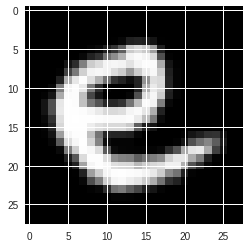

In [12]:
import matplotlib.pyplot as plt
img = x_train[samplenum]

# visualize image
plt.imshow(img[:,:,0], cmap='gray')

In [13]:
# show label for sample image
index = train_labels[samplenum][0]
class_idx[ index ]

'e'

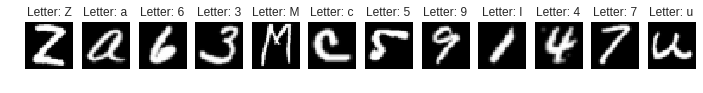

In [14]:
# visualize train samples
fig = plt.figure(figsize=(12,6))
for i in range(12):
  rows = 2
  columns = 12
  sp = fig.add_subplot( rows, columns , i+1)                 # plot a matrix with 2 rows and 12 columns
  sp.axis('Off')                                             # removes background grill
  img = x_train[i]                                        
  plt.imshow(img[:,:,0], cmap='gray', interpolation='none')  # prints image
  index = train_labels[i][0]
  plt.title("Letter: " + str( class_idx[ index ] ))          # adds title to the letter or number

## Reshape test labels

In [15]:
print ( test_labels.shape )
reshape = str(test_labels.shape).split(',')
reshape = int(reshape[0][1:])

(116323, 1)


In [16]:
test_labels = test_labels.reshape( reshape )
test_labels.shape

(116323,)

## Data augmentation
Use keras data augmentation.

In [0]:
batch_size = 512

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
gen = ImageDataGenerator(rotation_range=12, width_shift_range=0.1, shear_range=0.3,
                        height_shift_range=0.1, zoom_range=0.1, data_format='channels_last')
batches = gen.flow(x_train, y_train, batch_size=batch_size)
test_batches = gen.flow(x_test, y_test, batch_size=batch_size)
steps_per_epoch = int(np.ceil(batches.n/batch_size))
validation_steps = int(np.ceil(test_batches.n/batch_size))

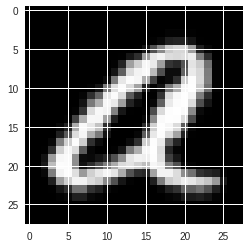

In [20]:
import matplotlib.pyplot as plt

# load ONE image from training set to display on screen
img = x_train[1]

# visualize original image
plt.imshow(img[:,:,0], cmap='gray')

In [0]:
# trick our generator into believing img has enough dimensions
# and get some augmented images for our single test image
img = np.expand_dims(img, axis=0)
aug_iter = gen.flow(img)

In [22]:
aug_img = next(aug_iter)[0].astype(np.float32)
aug_img.shape

(28, 28, 1)

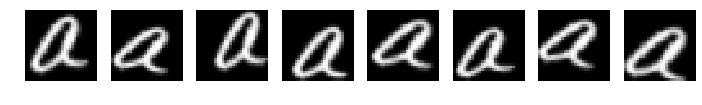

In [23]:
import matplotlib.pyplot as plt

# show augmented images
f = plt.figure(figsize=(12,6))
for i in range(8):
    sp = f.add_subplot(2, 26//3, i+1)
    sp.axis('Off')
    aug_img = next(aug_iter)[0].astype(np.float32)
    plt.imshow(aug_img[:,:,0], cmap='gray')                 # images are stored as (img_size, image_size, channel)  to print it we should call it img [;,;,0]

# Build the network

In [0]:
import os                    # Load os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

In [25]:
x_train.shape

(697932, 28, 28, 1)

In [26]:
len (y_train)

697932

In [0]:
# Architecture model 

#  Input Vector :  784 pixels (28x28)
#  Layer 1      :  128 nodes
#  Layer 2      :  128 nodes
#  Output Layer :  62 categories

In [0]:
ly1_neurons = 128
ly2_neurons = 128
categories = 62

# Define model architecture
model = Sequential()

## Input: 28x28 images with 1 channel -> (28, 28, 1) tensors.

## First layer
model.add(Conv2D(ly1_neurons, (3,3), input_shape = x_train.shape[1:]))    # adds 128 neurons with 3x3 window size
model.add(Activation("relu"))                                             # Activatior layer = relu (rectified linear regresion)
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

## Second layer
model.add(Conv2D(ly2_neurons, (3,3)))                                     # adds 128 neurons with 3x3 window size
model.add(Activation("relu"))                                             # Activatior layer = relu (rectified linear regresion)
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

## Third layer
model.add(Flatten())
model.add(Dense( categories ))                                            # to clasify in 62 classes
model.add(Activation('sigmoid'))                                          # Activatior layer = sigmoid

#Compile the network

In [0]:
# Compile model
model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

#Train the model

In [0]:
#  Log to be reviewed with tensorboard
import time
from tensorflow.keras.callbacks import TensorBoard

#Define log name
log_name = 'EMNIST byClass-cnn-'+str (ly1_neurons) +'x'+ str(ly2_neurons)+'-{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(log_name))
!mkdir /content/logs

In [31]:
batch_size = 128
epochs = 10

# Fit model on training data
history = model.fit(x_train, y_train
              , batch_size
              , epochs
              , verbose=1
              , callbacks = [tensorboard]
              , validation_data=(x_test, y_test)
             )

Train on 697932 samples, validate on 116323 samples
Epoch 1/10
697932/697932 [==============================] - 168s 241us/step - loss: 0.5248 - acc: 0.8251 - val_loss: 0.4125 - val_acc: 0.8543
Epoch 2/10
697932/697932 [==============================] - 160s 230us/step - loss: 0.4160 - acc: 0.8520 - val_loss: 0.3886 - val_acc: 0.8600
Epoch 3/10
697932/697932 [==============================] - 161s 230us/step - loss: 0.3947 - acc: 0.8582 - val_loss: 0.3859 - val_acc: 0.8625
Epoch 4/10
697932/697932 [==============================] - 161s 230us/step - loss: 0.3830 - acc: 0.8611 - val_loss: 0.3773 - val_acc: 0.8644
Epoch 5/10
697932/697932 [==============================] - 165s 236us/step - loss: 0.3754 - acc: 0.8630 - val_loss: 0.3726 - val_acc: 0.8650
Epoch 6/10
697932/697932 [==============================] - 166s 237us/step - loss: 0.3690 - acc: 0.8646 - val_loss: 0.3776 - val_acc: 0.8638
Epoch 7/10
697932/697932 [==============================] - 166s 238us/step - loss: 0.3649 - acc

## Evaluate final accuracy

In [40]:
# Evaluate model on test data
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print ('Test loss ', loss )
print ('Test accuracy ', accuracy )

Test loss  0.37407443057204304
Test accuracy  0.8646183471889446


## Saving model

In [41]:
save_dir = '/content/'
model_name = 'model - '+str (ly1_neurons) +'x'+ str(ly2_neurons)+' bs:' + str(batch_size) +' ep:'+ str(epochs) +' acc:'+ str(round(accuracy, 3)) +' loss:' + str(round(loss, 3)) +' .h5'

model_path = os.path.join(save_dir, model_name)
model.save( model_path )
print ('Saved trained model at ' + model_path )

Saved trained model at /content/model - 128x128 bs:128 ep:10 acc:0.865 loss:0.374 .h5


##Predict image

Text(0.5,1,'Letter: n')

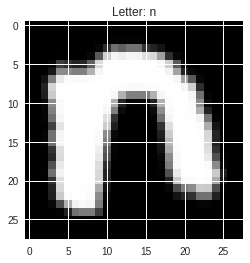

In [42]:
import random
image_index = random.randint(1,len(x_test))

image = x_test[image_index] # show label for sample image
plt.imshow(image[:,:,0], cmap='gray', interpolation='none')

image = np.expand_dims(image, axis=0)
scores = model.predict(image)

index = np.argmax(scores)
plt.title("Letter: " + str( class_idx[ index ] ))

# Plot training history

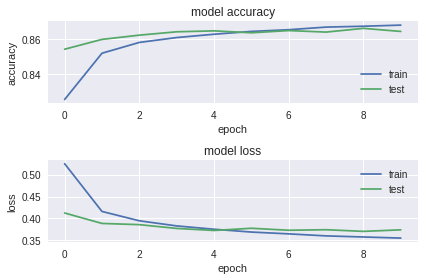

In [43]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

#Evaluate model performance

In [0]:
# load the model and create predictions on the test set
# model = load_model( model_name )
predicted_classes = model.predict_classes(x_test)

In [45]:
# see which we predicted correctly and which not
correct_indices = np.nonzero(predicted_classes == test_labels)[0]
incorrect_indices = np.nonzero(predicted_classes != test_labels)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")


100575  classified correctly
15748  classified incorrectly


## Visualize 12 correct prediction

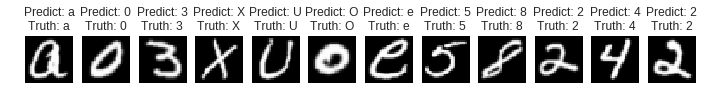

In [46]:
fig = plt.figure(figsize=(12,6))
for i, correct in enumerate(correct_indices[:12]):
  rows = 2
  columns = 12
  sp = fig.add_subplot( rows, columns , i+1)                 # plot a matrix with 2 rows and 12 columns
  sp.axis('Off')                                             # removes background grill
  img = x_train[i]                                        
  plt.imshow(x_test[correct].reshape(28,28), cmap='gray', interpolation='none')  # prints image
  plt.title(
      'Predict: ' + str(class_idx[predicted_classes[correct]]) +
      '\nTruth: ' + str(class_idx[test_labels[correct]])
  )

## Visualize 12 incorrect prediction

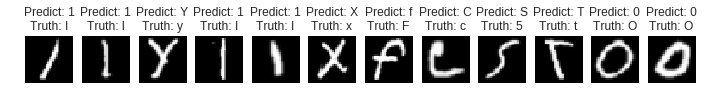

In [47]:
fig = plt.figure(figsize=(12,6))
for i, correct in enumerate(incorrect_indices[:12]):
  rows = 2
  columns = 12
  sp = fig.add_subplot( rows, columns , i+1)                 # plot a matrix with 2 rows and 12 columns
  sp.axis('Off')                                             # removes background grill
  img = x_train[i]                                        
  plt.imshow(x_test[correct].reshape(28,28), cmap='gray', interpolation='none')  # prints image
  plt.title(
      'Predict: ' + str(class_idx[predicted_classes[correct]]) +
      '\nTruth: ' + str(class_idx[test_labels[correct]])
  )